In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install import_ipynb 
!conda install -c conda-forge import_ipynb

/Users/gabesmithline/miniconda3/lib/python3.10/site-packages/conda/base/context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - import_ipynb

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://conda.anaconda.org/pytorch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at

In [3]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field
from math import prod, sqrt
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from prompts.make_prompt_bargain import make_prompt_bargain
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

pathology_results = pd.DataFrame()  
import itertools
envy_results_history = {}
from eval.metrics import *




Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-yvx3wa_o because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

In [4]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [10]:

import time
#prompt_style = 'llama_3.3_70b_maximize_value_outside_offer_cot_1_test'
prompt_style = 'openai_o1_maximize_value_outside_offer_cot_1_test'
# prompt_style = 'bargain_maximize_results_outside_offer_emphasized_with_example'
#prompt_style = 'anthropic_3_opus_maximize_value_outside_offer_cot_1' #claude sonnet is the model
#prompt_style = 'gemini_2.0_flash_maximize_value_outside_offer_cot_.8'
date = '1_18_2025'
#o1-2024-12-17
max_rounds = 3

def calculate_discounted_value(offer, values, gamma, realization_round):
    
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (realization_round - 1))

rounds = []
p1_values = []
p2_values = []
games = 3

pathology_results = pd.DataFrame()
envy_results_history = {}

for i in range(games):
    if (i + 1) % 10 == 0:
        print(f"Game {i + 1} of {games}")
        time.sleep(2 * 60)  #Sleep for 2 minutes

    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []
    

    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(llm_type="openai", player_num=0),
        player2_agent=llm_agent.LLMAgent(llm_type="openai", player_num=1),
        num_items=5,
        item_value_range=[1, 101], 
        gamma=0.9,
        max_rounds=max_rounds,
    ) 

    game_history = GameHistory(
        agent_1_name="Agent1",
        agent_2_name="Agent2",
        num_items=game.num_items,
        items=torch.tensor(game.items),
        agent_1_values=torch.tensor(game.player_values[0]),
        agent_2_values=torch.tensor(game.player_values[1]),
        agent_1_outside_value=game.outside_offer_values[0],
        agent_2_outside_value=game.outside_offer_values[1]
    )
   
    game_history.agent_1_offers = []
    game_history.agent_2_offers = []
    
    game.game_results = pd.DataFrame(columns=[  
        "game_num", 
        "round_num", 
        "player", 
        "discount_rate", 
        "offer", 
        "value", 
        "undiscounted_value",
        "items",
        "your_side_of_current_offer", 
        "outside_offer", 
        "outside_offer_undiscounted",
        "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", 
        "making_offer_worse_than_previous", 
        "nash_welfare",
        "proposal_proportion_player_1",
        "proposal_proportion_player_2",
        "concession_size", 
        "security_level_player_1", 
        "security_level_player_2", 
        "average_concession_size", 
        "rawlsian_welfare", 
        "gini_coefficient", 
        "utilitarian_welfare", 
        "jain_fairness_index",
        "on_pareto_frontier"
    ])
    
    pareto_front = compute_pareto_frontier(game.player_values[0], game.player_values[1], game.num_items, game.items, game.outside_offer_values)
    while game.in_progress:
        time.sleep(5) #Sleep for 5 seconds before taking a step
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round
        your_side_of_current_offer = None
        '''
        PATHOLOGIES
        '''
        making_offer_worse_than_previous = False  #Only occurs in non-final rounds
        making_offer_worse_than_outside_offer = False  #Only occurs in non-final rounds
        offer_no_items_or_all_items = False  #Only occurs in non-final rounds
        accepting_an_offer_worse_than_outside_offer = False  #Only occurs in final round
        walking_away_from_an_offer_better_than_outside_offer = False  #Only occurs in final round

        print(f"\n{'=' * 80}")
        print(f"Game {i + 1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'=' * 80}")

        prev_offer = game.current_offer
        game.step()

        if game.current_offer: 

            if game.players[current_player - 1].action == "COUNTEROFFER":
                if current_player == 1:
                    realization_round_p1 = current_round
                    realization_round_p2 = current_round
                else:
                    realization_round_p1 = current_round + 1
                    realization_round_p2 = current_round + 1 
            else: #realization round is the current round
                realization_round_p1 = current_round
                realization_round_p2 = current_round

            #calculate values with realization rounds
            # Corrected value calculations
            if current_player == 1 and game.players[current_player - 1].action == "COUNTEROFFER": #TODO: CAN REMOVE EXTRA COUNTEROFFER CONDITION
                p1_kept = game.items - np.array(game.current_offer.offer)
                p2_kept = np.array(game.current_offer.offer)
            elif current_player == 2 and game.players[current_player - 1].action == "COUNTEROFFER": #TODO: CAN REMOVE EXTRA COUNTEROFFER CONDITION 
                p1_kept = np.array(game.current_offer.offer)
                p2_kept = game.items - np.array(game.current_offer.offer)

            p1_value = calculate_discounted_value(
                p1_kept, game.player_values[0], game.gamma, realization_round_p1
            )
            p2_value = calculate_discounted_value(
                p2_kept, game.player_values[1], game.gamma, realization_round_p2
            )

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)

            if current_player == 1:
                p1_offers.append(game.current_offer.offer)
            else:
                p2_offers.append(game.current_offer.offer)
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")

            '''
            PATHOLOGY 1: Immediate offer was worse than the offer you just rejected
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (game.current_round == 1 and current_player == 2) or game.current_round > 1:
                    if current_player == 1:
                        your_side_of_previous_offer = p1_values[-2]  #P1's value from P2's previous offer
                        your_side_of_current_offer = p1_values[-1]  #P1's value from the current offer
                    else:
                        your_side_of_previous_offer = p2_values[-2]  #P2's value from P1's previous offer
                        your_side_of_current_offer = p2_values[-1]  #P2's value from the current offer

                    if your_side_of_previous_offer > your_side_of_current_offer:
                        making_offer_worse_than_previous = True
                    else:
                        making_offer_worse_than_previous = False

                '''
                PATHOLOGY 2: Immediate offer was worse than your outside offer
                '''
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** current_round) #discounted outside offer at next round
                    if p2_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
            else:
                making_offer_worse_than_outside_offer = False

            '''
            PATHOLOGY 3: Offer had no items or all items
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or
                        np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True
                else:
                    offer_no_items_or_all_items = False

            '''
            PATHOLOGY 4: Accepting an offer worse than your outside offer
            '''
            if game.final_action_player.action == "ACCEPT":
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True

            '''
            PATHOLOGY 5: Walking away from an offer better than your outside offer
            '''
            if game.final_action_player.action == "WALK" or (
                    current_player == 2 and
                    game.players[current_player - 1].action == "COUNTEROFFER" and
                    game.current_round == game.max_rounds):
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True
            
            '''
            NASH WELFARE:
            - Computes Nash Welfare of ACCEPT & COUNTEROFFERS
            - Computes Nash Welfare of WALK
            - Nash Welfare is computed at each step of the game
            '''
            if game.players[current_player - 1].action == "ACCEPT" or game.players[current_player - 1].action == "COUNTEROFFER":
                nash_welfare = sqrt(prod([np.dot(game.player_values[0], p1_kept), np.dot(game.player_values[1], p2_kept)])) #NASH WELFARE OF ACCEPTS & COUNTEROFFERS
            else:
                nash_welfare = sqrt(prod([game.outside_offer_values[0], game.outside_offer_values[1]]))
            '''
            CONCESSION SIZE:
            - min(0, value of current offer - value of previous offer)
            - Computed at each step of the game
            - Its none if the player walks away or accepts but is computed if a counteroffer is made
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER" and game.current_round > 1: 
                concession_size = min(0, np.dot(p1_kept, game.player_values[0]) - np.dot(game.player_values[0], game.items - p1_offers[-2])) if current_player == 1 else min(0, np.dot(p2_kept, game.player_values[1]) - np.dot(game.player_values[1], game.items - p2_offers[-2]))
            else:
                concession_size = None
            '''
            PROPOSAL PROPORTIONALITY:
            - Computed at each step of the game
            - Proposal Proportionality is computed at each step of the game
            '''
            proposal_proportion_player_1 = None if game.players[current_player - 1].action == "WALK" else np.dot(game.player_values[0], p1_kept) / sum([np.dot(game.player_values[0], p1_kept), np.dot(game.player_values[1], p2_kept)])
            proposal_proportion_player_2 = None if game.players[current_player - 1].action == "WALK" else np.dot(game.player_values[1], p2_kept) / sum([np.dot(game.player_values[0], p1_kept), np.dot(game.player_values[1], p2_kept)])
            '''
            UTILITARIAN WELFARE:
            - Computed at each step of the game
            - Utilitarian Welfare is computed at each step of the game
            '''
            utilitarian_welfare = sum([game.outside_offer_values[0], game.outside_offer_values[1]]) if game.players[current_player - 1].action == "WALK" else sum([np.dot(p1_kept, game.player_values[0]), np.dot(p2_kept, game.player_values[1])])
            '''
            RAWLSIAN WELFARE:
            - Computed at each step of the game
            - Rawlsian Welfare is computed at each step of the game
            '''
            rawlsian_welfare = min(game.outside_offer_values[0], game.outside_offer_values[1]) if game.players[current_player - 1].action == "WALK" else min(np.dot(p1_kept, game.player_values[0]), np.dot(p2_kept, game.player_values[1]))
            '''
            GINI COEFFICIENT:
            - Computed at each step of the game
            - Gini Coefficient is computed at each step of the game
            '''
            if game.players[current_player - 1].action == "WALK":
                wealth_distribution = np.array([game.outside_offer_values[0], game.outside_offer_values[1]], dtype=float)
            else:
                wealth_distribution = np.array([
                    np.dot(p1_kept, game.player_values[0]),
                    np.dot(p2_kept, game.player_values[1])
                ], dtype=float)
            total_wealth = np.sum(wealth_distribution)
            if total_wealth > 0:
                normalized_wealth = wealth_distribution / total_wealth
                gini_coefficient = 1 - np.sum(normalized_wealth ** 2)
            else:
                gini_coefficient = 0.0
            '''
            JAIN'S FAIRNESS INDEX:
            - Computed at each step of the game
            - Jain's Fairness Index is computed at each step of the game
            '''

            '''
            SECURITY LEVEL:
            - Computed at each step of the game
            - Security Level is computed at each step of the game
            '''
            security_level_player_1 = 0 if game.players[current_player - 1].action == "WALK" else max(0, game.outside_offer_values[0] - np.dot(game.player_values[0], p1_kept))
            security_level_player_2 = 0 if game.players[current_player - 1].action == "WALK" else max(0, game.outside_offer_values[1] - np.dot(game.player_values[1], p2_kept))

            '''
            ON PARETO FRONTIER:
            - Computed at start of the game
            - On Pareto Frontier is computed at each step of the game
            '''   
            on_pareto_frontier = False
            for vals in pareto_front:
                if np.array_equal(vals["agent1"], p1_kept) and np.array_equal(vals["agent2"], p2_kept):
                    on_pareto_frontier = True
                    break
            
            #ex_post_regret = compute_ex_post_regret(game.player_values[0], game.player_values[1], game.num_items, game.items, game.outside_offer_values)
            #ex_interim_regret = compute_ex_interim_regret(game.player_values[0], game.player_values[1], game.num_items, game.items, game.outside_offer_values)
            #concession_size_ratio = compute_concession_size_ratio(game.player_values[0], game.player_values[1], game.num_items, game.items, game.outside_offer_values)
            #gini_coefficient = compute_gini_coefficient(game.player_values[0], game.player_values[1], game.num_items, game.items, game.outside_offer_values)
            
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": game.current_offer.offer,
                "value": p1_value if current_player == 1 else p2_value,
                "undiscounted_value": p1_value / game.gamma ** (current_round - 1) if current_player == 1 else p2_value / game.gamma ** (current_round - 1),
                "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer,
                "outside_offer": outside_offer,
                "outside_offer_undiscounted": game.outside_offer_values[current_player - 1],
                "accepting_an_offer_worse_than_outside_offer": accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer": making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer": walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous,
                "nash_welfare": nash_welfare, 
                "proposal_proportion_player_1": proposal_proportion_player_1, 
                "proposal_proportion_player_2": proposal_proportion_player_2,
                "concession_size": concession_size, 
                "security_level_player_1": security_level_player_1,
                "security_level_player_2": security_level_player_2,
                "average_concession_size": None,
                "utilitarian_welfare": utilitarian_welfare,
                "rawlsian_welfare": rawlsian_welfare,
                "gini_coefficient": gini_coefficient,
                "jain_fairness_index": None,
                "on_pareto_frontier": on_pareto_frontier,
                #"proposal_proportionality": proposal_proportionality,
                #"ex-post_regret": ex_post_regret,
                #"ex-interim_regret": ex_interim_regret,
                #"concession_size_ratio": concession_size_ratio,
                #"gini_coefficient": gini_coefficient
            }])], ignore_index=True)

        '''
        FINAL POSSIBLE ROUND PRINT STATEMENTS
        '''
        if game.current_offer is not None and len(game.current_offer.offer) == game.num_items:
            
            game_history.add_offer(
                game.current_player,
                Offer(game.current_player, offer=torch.tensor(game.current_offer.offer))
            )

        if current_round == game.max_rounds and current_player == 2:
            if game.current_offer and game.current_offer != prev_offer:
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer:
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(
                    p1_kept, game.player_values[0], game.gamma, current_round
                )
                p2_value = calculate_discounted_value(
                    game.current_offer.offer, game.player_values[1], game.gamma, current_round
                )
            else:
                
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")

            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
        elif game.current_offer is None and current_player == 1 and game.final_action_player.action == "WALK":
            # If Player 1 makes an invalid offer
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": [],
                "value": None,
                "items": game.items,
                "your_side_of_current_offer": None,
                "outside_offer": None,
                "accepting_an_offer_worse_than_outside_offer": None,
                "making_an_offer_worse_for_you_than_your_outside_offer": None,
                "walking_away_from_an_offer_better_than_your_outside_offer": None,
                "offer_no_items_or_all_items": None,
                "making_offer_worse_than_previous": None,
                "security_level_player_1": None,
                "security_level_player_2": None,
                "average_concession_size": None,
                "nash_welfare": nash_welfare,
                "utilitarian_welfare": utilitarian_welfare,
                "rawlsian_welfare": rawlsian_welfare,
                "gini_coefficient": gini_coefficient,
                "security_level_player_1": security_level_player_1,
                "security_level_player_2": security_level_player_2,
                "jain_fairness_index": None,
                "proposal_proportion_player_1": proposal_proportion_player_1,
                "proposal_proportion_player_2": proposal_proportion_player_2,
                "concession_size": None,
            }])], ignore_index=True)
            game.in_progress = False

    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
    '''
    SECURITY LEVEL (undiscounted):
    - Computed at end of game
    - If player walks away, security level is 0
    - If player accepts, security level is max(0, outside_offer_value - current_offer_value)
    '''
   
        
   
    envy_results_history[i] = game_history

pathology_results.to_csv(f'pathology_results_{date}_{games}_{prompt_style}.csv', index=False)

# pd.DataFrame.from_dict(envy_results_history, orient='index').to_csv(
#     f'envy_results_{date}_{games}_{prompt_style}.csv', index=False
# )


Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 1 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 1 to 101.
    Your private values are 77 for item 1, 27 for item 2, 21 for item 3, 45 for item 4, 24 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 591. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 291. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_26362/1669796801.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


KeyboardInterrupt: 

## Statistics of Play for Each Player Over Games

In [16]:
# Read the CSV data
import pandas as pd
#/Users/gabesmithline/Desktop/caif_negotiation/experiments/2025_1_5/llama/basic_maximize_value_outside_offer_cot/pathology_results_1_5_2025_100_llama_3.1_405b_maximize_value_outside_offer_cot_.9.csv
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#df = pd.read_csv("/Users/gabesmithline/Desktop/caif_negotiation/experiments/2025_1_4/llama/basic_maximize_value_outside_offer_cot/pathology_results_1_4_2025_100_llama_3.1_405b_maximize_value_outside_offer_cot_1.csv")
def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        #first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()
        first_game_ending_indices = game_ending_moves.groupby('game_num').first().reset_index()['round_num']
        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_indices.index:
                #pathology_round = first_game_ending_round.loc[game_num]
                first_pathology_index = first_game_ending_indices.loc[game_num]

                #return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
                return group[group['round_num'] < first_pathology_index]  # Exclude the pathology round and after
            else:
                return group  

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 0/3 (0.0%)
Player 1: 0/3 (0.0%)
Player 2: 0/3 (0.0%)
Round 1: 0/3 (0.0%)
Round 2: 0/3 (0.0%)
Round 3: 0/3 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/3 (0.0%)
Player 1: 0/3 (0.0%)
Player 2: 0/3 (0.0%)
Round 1: 0/3 (0.0%)
Round 2: 0/3 (0.0%)
Round 3: 0/3 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 3/8 (37.5%)
Player 1: 3/5 (60.0%)
Player 2: 0/3 (0.0%)
Round 1: 2/5 (40.0%)
Round 2: 1/2 (50.0%)
Round 3: 0/1 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 0/8 (0.0%)
Player 1: 0/5 (0.0%)
Player 2: 0/3 (0.0%)
Round 1: 0/5 (0.0%)
Round 2: 0/2 (0.0%)
Round 3: 0/1 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 0/8 (0.0%)
Player 1: 0/5 (0.0%)
Player 2: 0/3 (0.0%)
Round 1: 0/5 (0.0%)
Round 2: 0/2 (0.0%)
Round 3: 0/1 (0.0%)


## Compute Bargaining Metrics

## Compute Envy Free Results By Game

In [7]:
#Loop through envy_results_history and compute envy free results
envy_results_by_game = pd.DataFrame()
envy_results_by_game.columns = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "outside_offer_consistency", "offer_increasing", "envy_free_strict", "envy_free_exclude_one_item"
    ])
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    evaluator = GameEvaluator(game)
    print(f"Outside offer consistency: {evaluator.evaluate_outside_offer_consistency()}")
    print(f"Offer increasing: {evaluator.evaluate_offer_increasing()}")
    print(f"Envy-free (strict): {evaluator.evaluate_envy_free()}")
    print(f"Envy-free (exclude one item): {evaluator.evaluate_envy_free(exclude_one_item=True)}")
    envy_results_by_game = pd.concat([envy_results_by_game, pd.DataFrame([{
        "game_num": i, "outside_offer_consistency": evaluator.evaluate_outside_offer_consistency(),
        "offer_increasing": evaluator.evaluate_offer_increasing(), "envy_free_strict": evaluator.evaluate_envy_free(),
        "envy_free_exclude_one_item": evaluator.evaluate_envy_free(exclude_one_item=True)
    }])], ignore_index=True)

#percentage of games that are envy free
print(f"Envy free (strict): {envy_results_by_game['envy_free_strict'].value_counts() / len(envy_results_by_game)}")
print(f"Envy free (exclude one item): {envy_results_by_game['envy_free_exclude_one_item'].value_counts() / len(envy_results_by_game)}")
print(f"Outside offer consistency: {envy_results_by_game['outside_offer_consistency'].value_counts() / len(envy_results_by_game)}")
print(f"Offer increasing: {envy_results_by_game['offer_increasing'].value_counts() / len(envy_results_by_game)}")



Game 1:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 2:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 3:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): False
Envy-free (exclude one item): False
Envy free (strict): envy_free_strict
True     0.666667
False    0.333333
Name: count, dtype: float64
Envy free (exclude one item): envy_free_exclude_one_item
True     0.666667
False    0.333333
Name: count, dtype: float64
Outside offer consistency: outside_offer_consistency
False    1.0
Name: count, dtype: float64
Offer increasing: offer_increasing
True    1.0
Name: count, dtype: float64


## Envy Free Results by Player

In [8]:
envy_results_history_copy = envy_results_history.copy()
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    print(f"Game History Values:")
    for player in [0, 1]:
        player_offers = game.get_offers(player)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        outside_value = game.agent_1_outside_value if player == 0 else game.agent_2_outside_value
        
        print(f"\nPlayer {player + 1}:")
        print(f"Outside offer value: {outside_value}")
        
        for i, offer in enumerate(player_offers):
            given_value = torch.dot(player_values, offer.offer)
            total_value = torch.dot(player_values, game.items)
            kept_value = total_value - given_value
            
            print(f"Offer {i + 1}:")
            print(f"  Offer: {offer.offer}")
            print(f"  Player values: {player_values}")
            print(f"  Value calculation:")
            print(f"    Total value: {total_value.item()} = {player_values} · {game.items}")
            print(f"    Given value: {given_value.item()} = {player_values} · {offer.offer}")
            print(f"    Kept value: {kept_value.item()} = {total_value.item()} - {given_value.item()}")
            print(f"  Value of kept items: {kept_value.item()}")

    print("\nEnvy-free evaluation details:")
    for player in [0, 1]:
        opponent = 1 - player
        player_offers = game.get_offers(player)
        opponent_offers = game.get_offers(opponent)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        
        print(f"\nPlayer {player + 1}:")
        for i, offer in enumerate(player_offers):
            if i < len(opponent_offers):
                opp_offer = opponent_offers[i]
                player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                
                print(f"Round {i + 1}:")
                print(f"  Player's offer: {offer.offer}")
                print(f"  Opponent's offer: {opp_offer.offer}")
                print(f"  Player's bundle value: {player_bundle_value.item()} = {player_values} · ({game.items} - {offer.offer})")
                print(f"  Opponent's bundle value (to player): {opponent_bundle_value.item()} = {player_values} · ({game.items} - {opp_offer.offer})")
                
                if player_bundle_value >= opponent_bundle_value:
                    print("  Envy-free: Yes")
                else:
                    print("  Envy-free: No")
                    print("  Checking if removing one item makes it envy-free:")
                    for j in range(len(game_history.items)):
                        temp_opp_offer = opp_offer.offer.clone()
                        if temp_opp_offer[j] > 0:
                            temp_opp_offer[j] -= 1
                            temp_opponent_bundle_value = torch.dot(player_values, game.items - temp_opp_offer)
                            print(f"    Removing item {j + 1}: {temp_opponent_bundle_value.item()} = {player_values} · ({game.items} - {temp_opp_offer})")
                            if player_bundle_value >= temp_opponent_bundle_value:
                                print(f"    Envy-free after removing item {j + 1}: Yes")
                                break
                    else:
                        print("    Envy-free after removing any single item: No")


Game 1:
Game History Values:

Player 1:
Outside offer value: 193

Player 2:
Outside offer value: 881
Offer 1:
  Offer: tensor([4, 1, 5, 0, 2])
  Player values: tensor([ 9, 11, 72, 34, 15])
  Value calculation:
    Total value: 900 = tensor([ 9, 11, 72, 34, 15]) · tensor([8, 3, 9, 3, 3])
    Given value: 437 = tensor([ 9, 11, 72, 34, 15]) · tensor([4, 1, 5, 0, 2])
    Kept value: 463 = 900 - 437
  Value of kept items: 463

Envy-free evaluation details:

Player 1:

Player 2:
Game 2:
Game History Values:

Player 1:
Outside offer value: 899
Offer 1:
  Offer: tensor([0, 1, 0, 2, 0])
  Player values: tensor([ 77, 100,  47,  23,  49])
  Value calculation:
    Total value: 983 = tensor([ 77, 100,  47,  23,  49]) · tensor([2, 4, 3, 4, 4])
    Given value: 146 = tensor([ 77, 100,  47,  23,  49]) · tensor([0, 1, 0, 2, 0])
    Kept value: 837 = 983 - 146
  Value of kept items: 837
Offer 2:
  Offer: tensor([0, 2, 1, 2, 1])
  Player values: tensor([ 77, 100,  47,  23,  49])
  Value calculation:
    

In [9]:
print("Checking envy_results_history structure:")
print(f"Type: {type(envy_results_history_copy.items())}")
print(f"Length: {len(envy_results_history_copy.items())}")
if len(envy_results_history_copy.items()) > 0:
    first_game = next(iter(envy_results_history_copy.items()))[1]
    print("\nFirst game attributes:")
    print(f"Has items: {hasattr(first_game, 'items')}")
    print(f"Has agent_1_values: {hasattr(first_game, 'agent_1_values')}")
    print(f"Has agent_1_outside_value: {hasattr(first_game, 'agent_1_outside_value')}")
    print(f"Has get_offers method: {hasattr(first_game, 'get_offers')}")
    if hasattr(first_game, 'get_offers'):
        print(f"Number of offers player 1: {len(first_game.get_offers(0))}")
        print(f"Number of offers player 2: {len(first_game.get_offers(1))}")

Checking envy_results_history structure:
Type: <class 'dict_items'>
Length: 3

First game attributes:
Has items: True
Has agent_1_values: True
Has agent_1_outside_value: True
Has get_offers method: True
Number of offers player 1: 0
Number of offers player 2: 1


In [10]:
#TODO: Move this to metrics/envy_free_analysis.py
def analyze_envy_freeness_comprehensive(game_history):
    total_games = len(game_history)
    moves_data = []
    game_properties = []
    
    for game_id, game in game_history.items():
        evaluator = GameEvaluator(game)
        max_round = max(len(game.get_offers(0)), len(game.get_offers(1)))
        
        # Track game-level properties
        is_outside_consistent = evaluator.evaluate_outside_offer_consistency()
        is_offer_increasing = evaluator.evaluate_offer_increasing()
        is_final_allocation = evaluator.evaluate_envy_free()
        is_final_one_item_ef = evaluator.evaluate_envy_free(exclude_one_item=True)
        
        game_properties.append({
            'game_num': game_id,
            'rounds_played': max_round,
            'outside_consistent': is_outside_consistent,
            'offer_increasing': is_offer_increasing
        })
        
        for round_num in range(max_round):
            steps_in_round = 0
            for player in [0, 1]:
                opponent = 1 - player
                player_offers = game.get_offers(player)
                opponent_offers = game.get_offers(opponent)
                
                is_last_step = (round_num == max_round - 1 and 
                              round_num >= len(opponent_offers) - 1)
                
                if round_num < len(player_offers):
                    steps_in_round += 1
                    player_values = game.agent_1_values if player == 0 else game.agent_2_values
                    offer = player_offers[round_num]
                    
                    if round_num < len(opponent_offers):
                        opp_offer = opponent_offers[round_num]
                        player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                        opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                        
                        is_strict_ef = bool(player_bundle_value >= opponent_bundle_value)
                        is_one_item_ef = False
                        
                        if not is_strict_ef:
                            for j in range(len(game.items)):
                                temp_opp_offer = opp_offer.offer.clone()
                                if temp_opp_offer[j] > 0:
                                    temp_opp_offer[j] -= 1
                                    temp_value = torch.dot(player_values, game.items - temp_opp_offer)
                                    if player_bundle_value >= temp_value:
                                        is_one_item_ef = True
                                        break
                        
                        moves_data.append({
                            'game_num': game_id,
                            'round_num': round_num + 1,
                            'step_num': steps_in_round,
                            'player': player + 1,
                            'is_strict_ef': is_strict_ef,
                            'is_one_item_ef': is_one_item_ef,
                            'is_final_allocation': is_last_step,
                            'final_strict_ef': is_final_allocation if is_last_step else False,
                            'final_one_item_ef': is_final_one_item_ef if is_last_step else False,
                            'outside_consistent': is_outside_consistent,
                            'offer_increasing': is_offer_increasing
                        })
    
    df = pd.DataFrame(moves_data)
    game_props_df = pd.DataFrame(game_properties)
    
    def print_stats(group, name):
        strict_ef_count = group['is_strict_ef'].sum()
        one_item_ef_count = group['is_one_item_ef'].sum()
        outside_consistent_count = group['outside_consistent'].sum()
        offer_increasing_count = group['offer_increasing'].sum()
        count = len(group)
        
        print(f"\n=== {name} ===")
        print(f"Count: {count}")
        print(f"Strict Envy-Free: {strict_ef_count}/{count} ({(strict_ef_count/count*100):.1f}%)")
        print(f"One-Item Envy-Free: {one_item_ef_count}/{count} ({(one_item_ef_count/count*100):.1f}%)")
        print(f"Outside Offer Consistent: {outside_consistent_count}/{count} ({(outside_consistent_count/count*100):.1f}%)")
        print(f"Offer Increasing: {offer_increasing_count}/{count} ({(offer_increasing_count/count*100):.1f}%)")
    
    print("\nGAME LENGTH STATISTICS")
    print(f"Average rounds per game: {game_props_df['rounds_played'].mean():.1f}")
    print(f"Max rounds in any game: {game_props_df['rounds_played'].max()}")
    print(f"Min rounds in any game: {game_props_df['rounds_played'].min()}")
    
    # Overall game properties
    print("\nOVERALL GAME PROPERTIES")
    print(f"Outside Offer Consistent: {game_props_df['outside_consistent'].sum()}/{total_games} ({(game_props_df['outside_consistent'].sum()/total_games*100):.1f}%)")
    print(f"Offer Increasing: {game_props_df['offer_increasing'].sum()}/{total_games} ({(game_props_df['offer_increasing'].sum()/total_games*100):.1f}%)")
    
    # Overall statistics
    print("\nOVERALL STATISTICS")
    print(f"Total Games: {total_games}")
    print(f"Total Moves: {len(df)}")
    
    # Final allocation statistics
    final_moves = df[df['is_final_allocation']]
    final_strict = final_moves.groupby('game_num')['final_strict_ef'].any()
    final_one_item = final_moves.groupby('game_num')['final_one_item_ef'].any()
    
    print("\nFINAL ALLOCATION STATISTICS")
    print(f"Strict Envy-Free: {final_strict.sum()}/{total_games} ({(final_strict.sum()/total_games*100):.1f}%)")
    print(f"One-Item Envy-Free: {final_one_item.sum()}/{total_games} ({(final_one_item.sum()/total_games*100):.1f}%)")
    
    # By Player
    for player in [1, 2]:
        player_moves = df[df['player'] == player]
        print_stats(player_moves, f"Player {player}")
    
    # By Round
    for round_num in sorted(df['round_num'].unique()):
        round_moves = df[df['round_num'] == round_num]
        print_stats(round_moves, f"Round {round_num}")
        
        # By Step within Round
        for step_num in sorted(round_moves['step_num'].unique()):
            step_moves = round_moves[round_moves['step_num'] == step_num]
            print_stats(step_moves, f"Round {round_num} - Step {step_num}")
        
        # By Player within Round
        for player in [1, 2]:
            player_round_moves = round_moves[round_moves['player'] == player]
            print_stats(player_round_moves, f"Round {round_num} - Player {player}")

    return df

envy_stats_df = analyze_envy_freeness_comprehensive(envy_results_history_copy)  
#save to csv
envy_stats_df.to_csv(f'envy_stats_df_{date}_{games}_{prompt_style}.csv', index=False)



GAME LENGTH STATISTICS
Average rounds per game: 1.3
Max rounds in any game: 2
Min rounds in any game: 1

OVERALL GAME PROPERTIES
Outside Offer Consistent: 0/3 (0.0%)
Offer Increasing: 3/3 (100.0%)

OVERALL STATISTICS
Total Games: 3
Total Moves: 6

FINAL ALLOCATION STATISTICS
Strict Envy-Free: 1/3 (33.3%)
One-Item Envy-Free: 1/3 (33.3%)

=== Player 1 ===
Count: 3
Strict Envy-Free: 3/3 (100.0%)
One-Item Envy-Free: 0/3 (0.0%)
Outside Offer Consistent: 0/3 (0.0%)
Offer Increasing: 3/3 (100.0%)

=== Player 2 ===
Count: 3
Strict Envy-Free: 1/3 (33.3%)
One-Item Envy-Free: 0/3 (0.0%)
Outside Offer Consistent: 0/3 (0.0%)
Offer Increasing: 3/3 (100.0%)

=== Round 1 ===
Count: 4
Strict Envy-Free: 3/4 (75.0%)
One-Item Envy-Free: 0/4 (0.0%)
Outside Offer Consistent: 0/4 (0.0%)
Offer Increasing: 4/4 (100.0%)

=== Round 1 - Step 1 ===
Count: 2
Strict Envy-Free: 2/2 (100.0%)
One-Item Envy-Free: 0/2 (0.0%)
Outside Offer Consistent: 0/2 (0.0%)
Offer Increasing: 2/2 (100.0%)

=== Round 1 - Step 2 ===
Co

## Statistics 

In [11]:
# Statistics of Envy Free Results
import pandas as pd
import torch
def compute_statistics(envy_results_history):
    # Initialize dictionaries to store statistics
    game_stats = []
    round_stats = []
    player_stats = []
    
    print(f"Number of games in history: {len(envy_results_history)}")  # Debug print
    
    for game_id, game in envy_results_history.items():
        print(f"Processing game {game_id + 1}")  # Debug print
        
        # Game level statistics
        game_data = {
            'game_id': game_id + 1,
            'total_rounds': len(game.get_offers(0)),
            'player1_outside_value': game.agent_1_outside_value,
            'player2_outside_value': game.agent_2_outside_value,
            'total_items': len(game.items)
        }
        game_stats.append(game_data)
        
        # Process each player's offers and values
        for player in [0, 1]:
            player_offers = game.get_offers(player)
            player_values = game.agent_1_values if player == 0 else game.agent_2_values
            opponent = 1 - player
            opponent_offers = game.get_offers(opponent)
            
            print(f"  Player {player + 1} has {len(player_offers)} offers")  # Debug print
            
            # Player level statistics
            player_data = {
                'game_id': game_id + 1,
                'player_id': player + 1,
                'total_value': torch.dot(player_values, game.items).item(),
                'outside_value': game.agent_1_outside_value if player == 0 else game.agent_2_outside_value,
                'num_offers': len(player_offers)
            }
            player_stats.append(player_data)
            
            # Round level statistics
            for round_id, (offer, opp_offer) in enumerate(zip(player_offers, opponent_offers)):
                given_value = torch.dot(player_values, offer.offer).item()
                kept_value = torch.dot(player_values, game.items - offer.offer).item()
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer).item()
                
                is_envy_free = kept_value >= opponent_bundle_value
                
                round_data = {
                    'game_id': game_id + 1,
                    'round_id': round_id + 1,
                    'player_id': player + 1,
                    'given_value': given_value,
                    'kept_value': kept_value,
                    'opponent_bundle_value': opponent_bundle_value,
                    'is_envy_free': is_envy_free
                }
                round_stats.append(round_data)
    
    print(f"\nStatistics summary:")  # Debug prints
    print(f"Number of game records: {len(game_stats)}")
    print(f"Number of player records: {len(player_stats)}")
    print(f"Number of round records: {len(round_stats)}")
    
    # Convert to DataFrames and save to CSV
    game_df = pd.DataFrame(game_stats)
    round_df = pd.DataFrame(round_stats)
    player_df = pd.DataFrame(player_stats)
    
    # Save to CSV files
    game_df.to_csv('game_statistics.csv', index=False)
    round_df.to_csv('round_statistics.csv', index=False)
    player_df.to_csv('player_statistics.csv', index=False)
    
    # Print first few rows of each DataFrame
    print("\nFirst few rows of game statistics:")
    print(game_df.head())
    print("\nFirst few rows of player statistics:")
    print(player_df.head())
    print("\nFirst few rows of round statistics:")
    print(round_df.head())
    
    return game_df, round_df, player_df

game_df, round_df, player_df = compute_statistics(envy_results_history)


Number of games in history: 3
Processing game 1
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 2
  Player 1 has 2 offers
  Player 2 has 2 offers
Processing game 3
  Player 1 has 1 offers
  Player 2 has 1 offers

Statistics summary:
Number of game records: 3
Number of player records: 6
Number of round records: 6

First few rows of game statistics:
   game_id  total_rounds  player1_outside_value  player2_outside_value  \
0        1             0                    193                    881   
1        2             2                    899                    306   
2        3             1                    781                    113   

   total_items  
0            5  
1            5  
2            5  

First few rows of player statistics:
   game_id  player_id  total_value  outside_value  num_offers
0        1          1         1015            193           0
1        1          2          900            881           1
2        2          1          983           

In [12]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



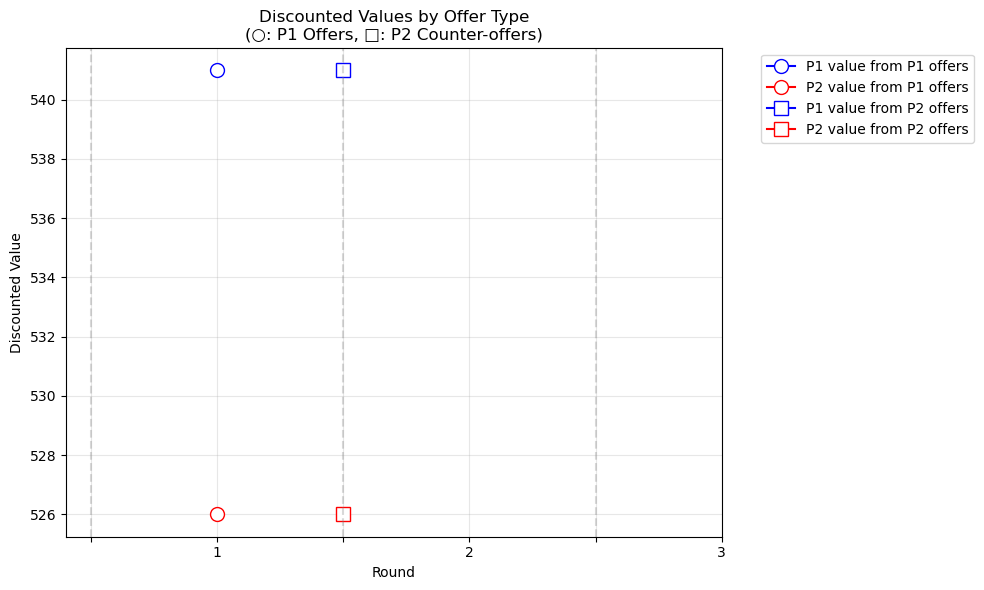

In [13]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 2
Number of P1 offers: 1
Number of P2 offers: 1


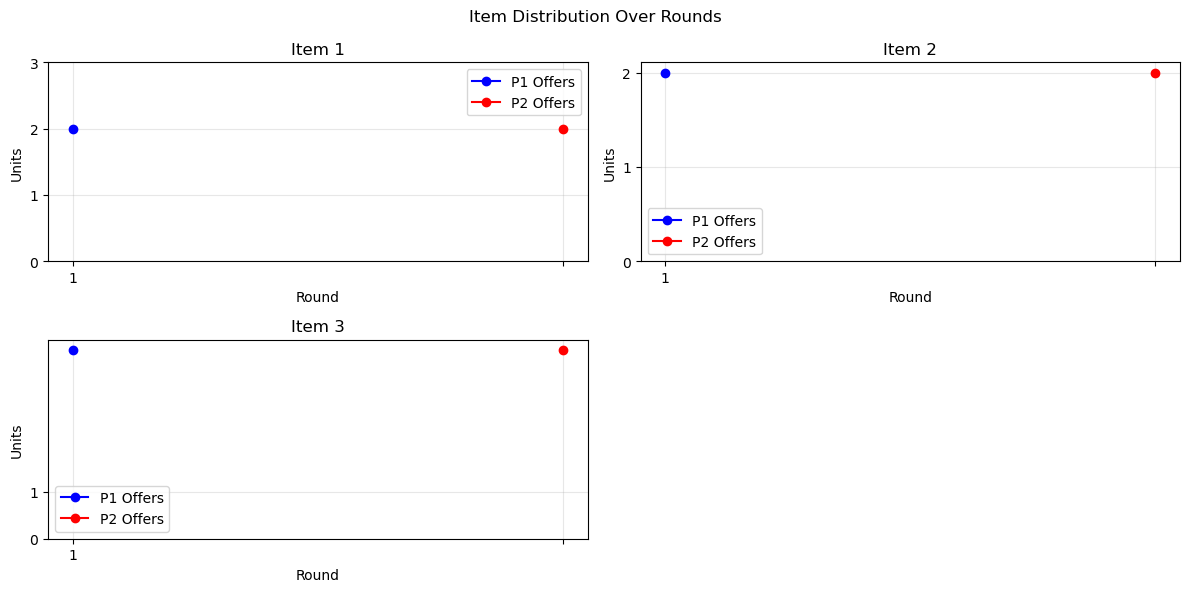

In [14]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [15]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Long

## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
